### Importing necessary libraries ###

In [1]:
import os 
import time
import random

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

import tqdm

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import ConcatDataset
from torch.utils.data.dataset import random_split



### Aranging Cuda Settings to get higher speed ###

In [2]:
# setting device as GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# CUDA device information
if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Memory Stats:')
    print('  - Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('  - Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    print('  - Total:    ', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using device: cuda
GPU Name: NVIDIA GeForce RTX 2060
Memory Stats:
  - Allocated: 0.0 GB
  - Cached:    0.0 GB
  - Total:     6.0 GB


In [3]:
# transformation of images
transforming_img = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  
    transforms.Normalize([0.5,0.5,0.5], 
                        [0.5,0.5,0.5])
])

In [4]:
# paths of train and test datasets
train_path = ('./brain_mri_dataset/Training/')
test_path = ('./brain_mri_dataset/Testing/')

# Gettings the datasets and combining them to shuffle all dataset and 
# to split it for extra dataset of validation
train_dataset=ImageFolder(train_path,transform=transforming_img)
test_dataset=ImageFolder(test_path,transform=transforming_img)
concated_dataset = ConcatDataset([train_dataset,test_dataset])

In [5]:
# aranging sizes of train, val, test datasets
train_size = int(0.8 * len(concated_dataset))
val_size = int(0.1 * len(concated_dataset))
test_size = len(concated_dataset) - (train_size + val_size)
len(concated_dataset),train_size, val_size, test_size

(3264, 2611, 326, 327)

In [6]:
#splitting the dataset
train_set, val_set, test_set= random_split(concated_dataset, [train_size, val_size,test_size])

#### Maybe some data visualizations...

## Models

In [7]:
class CNN(nn.Module):
    def __init__(self,num_classes=4):
        super(CNN,self).__init__()
        self.conv1=nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        self.bn1=nn.BatchNorm2d(num_features=12)
        self.relu1=nn.ReLU()        
        self.pool=nn.MaxPool2d(kernel_size=2)
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
        
        #Feed forwad function
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
        output=self.pool(output)
        output=self.conv2(output)
        output=self.relu2(output)
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)            
        output=output.view(-1,32*75*75)
        output=self.fc(output)
            
        return output
CNN_model = CNN()

In [8]:
# Resnet pre-trained model
model_resnet_pretrained=models.resnet18(pretrained=True)
for param in model_resnet_pretrained.parameters():
    param.requires_grad = False
# Getting features
features=model_resnet_pretrained.fc.in_features
# Adding linear layer to classify 4 classes
model_resnet_pretrained.fc=nn.Linear(features,4)

C:\Users\ata_h\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ata_h\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
model_resnet_not_pretrained=models.resnet18(pretrained=False)
for param in model_resnet_not_pretrained.parameters():
    param.requires_grad = False
# Getting features
features=model_resnet_not_pretrained.fc.in_features
# Adding linear layer to classify 4 classes
model_resnet_not_pretrained.fc=nn.Linear(features,4)

C:\Users\ata_h\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [10]:
model_efficientnet_b0_pretrained = models.efficientnet_b0(pretrained=True)

for param in model_efficientnet_b0_pretrained.parameters():
    param.requires_grad = False
    
num_inputs = model_efficientnet_b0_pretrained.classifier[1].in_features
model_efficientnet_b0_pretrained.classifier = nn.Sequential(nn.Linear(num_inputs, 4))

C:\Users\ata_h\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
model_efficientnet_b0_not_pretrained = models.efficientnet_b0(pretrained=True)

for param in model_efficientnet_b0_not_pretrained.parameters():
    param.requires_grad = False

num_inputs = model_efficientnet_b0_not_pretrained.classifier[1].in_features
model_efficientnet_b0_not_pretrained.classifier = nn.Sequential(nn.Linear(num_inputs, 4))

## Train, inference and test functions ##

In [12]:
def inference (model, val_set, val_batch):
    # passing model to device to use GPU
    model = model.to(device)
    # Loading the data
    val_loader = DataLoader(val_set, batch_size=val_batch, shuffle=True)
    # Defining loss function(criterion)
    criterion = nn.CrossEntropyLoss()
    
    true_prediction = 0
    total_predictions = 0
    running_loss = 0
    
    # Disabling gradient updates for inference process
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            # Get the input features and target labels, and put them on the GPU
            inputs=images.to(device)
            labels = labels.to(device)
            # Get predictions
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            # Count of predictions that matched the target label
            true_prediction += (prediction == labels).sum().item()
            total_predictions += prediction.shape[0]

        batch_number = len(val_loader)
        avg_loss = running_loss / batch_number
        accuracy = true_prediction/total_predictions
        return avg_loss, accuracy

In [22]:
def train(model,train_set,val_set,max_epoch,train_batch,val_batch,learning_rate):
    # passing model to device to use GPU
    model = model.to(device) 
    # Loading the data
    train_loader = DataLoader(train_set, batch_size=train_batch, shuffle=True)
    # Defining loss function(criterion) and optimizer with parameters
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Creating lists to store data from the training process
    Train_loss_list = []
    Val_loss_list = []
    Train_acc_list = []
    Val_acc_list = []
    n = len(train_loader)
    
    for epoch in range(max_epoch):
        true_prediction = 0
        total_predictions = 0  
        running_loss=0
        running_acc = 0
        with tqdm.tqdm(total= n, desc=f"Epoch {epoch+1}") as pbar:
            for i, (images, labels) in enumerate(train_loader):
                # passing inputs to device to use GPU
                images = images.to(device)
                labels = labels.to(device)     

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                

                # Get the predicted class with the highest score
                _, prediction = torch.max(outputs,1) # no need for first return
                # Count of predictions that matched the target label
                true_prediction += (prediction == labels).sum().item()
                total_predictions += prediction.shape[0]
                # update acc
                running_acc = true_prediction/total_predictions
                
                # Update progress bar
                pbar.update(1)
                pbar.set_postfix(train_loss=loss.item(),train_acc=running_acc)
                running_loss += loss.item()
                
        batch_number = len(train_loader)
        avg_loss = running_loss / batch_number
        train_acc = true_prediction/total_predictions
        val_loss, val_acc = inference(model, val_set, val_batch)    
        Train_loss_list.append(avg_loss)
        Val_loss_list.append(val_loss)
        Val_acc_list.append(val_acc)
        Train_acc_list.append(train_acc)
    return Train_loss_list, Val_loss_list, Val_acc_list, Train_acc_list

In [23]:
def plot(train_param, val_param, metric):
    plt.figure(figsize = (12,6))
    plt.plot(train_param, label="Training set")
    plt.plot(val_param, label="Validation set")
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.legend()
    plt.show()

In [24]:
def test(model,test_set):
    
    # passing model to device to use CPU
    model = model.to('cpu') 
    
    # Loading the data
    test_loader = DataLoader(test_set, batch_size=test_batch, shuffle=True)
    
    # Defining loss function(criterion) and optimizer with parameters
    criterion = nn.CrossEntropyLoss()

    correct_prediction = 0
    total_prediction = 0
    running_loss = 0
    
    # Creating lists to store data from the training process
    cm_list=[]
    f_score_list=[]
    p_score_list=[]
    r_score_list=[]
    test_acc_list=[]
    
    # Disable gradient updates
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
                        
            # Get the input features and target labels, and put them on the GPU
            inputs=images.to('cpu')
            labels = labels.to('cpu')
            
            
            # Get predictions
            model = model.to('cpu')
            outputs = model(inputs).to('cpu')

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)

            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

            f1 = f1_score(labels, prediction, average='macro', zero_division=1)
            precision=precision_score(labels, prediction, average='macro', zero_division=1)
            recall=recall_score(labels, prediction, average='macro', zero_division=1)
            cm = confusion_matrix(labels,prediction)
            accuracy = correct_prediction/total_prediction

            cm_list.append(cm)
            f_score_list.append(f1)
            p_score_list.append(precision)
            r_score_list.append(recall)
            test_acc_list.append(accuracy)
    return test_acc_list, f_score_list, p_score_list, r_score_list, cm_list

In [25]:
def report_test(test_acc_list, f_score_list, p_score_list, r_score_list, cm_list):
    print(f"Test accuracy is {sum(test_acc_list)/len(test_acc_list)}") # Note that these are average scores
    print(f"F score is {sum(f_score_list)/len(f_score_list)}")
    print(f"Precision is {sum(p_score_list)/len(p_score_list)}")
    print(f"Recall is {sum(r_score_list)/len(r_score_list)}")
    print(f"Confusion matrix is below \n {sns.heatmap(sum(cm_list), annot=True)}") # 

### Save and load model functions ###

In [26]:
def save_model(model, filepath): # saving the evaluated model
    # Save the model to a file
    torch.save(model, filepath)
    # Save the model's weights and biases
    torch.save(model.state_dict(), filepath + '_weights.pt')

In [27]:
def load_model(filepath): # loading the model if necessary
    # Load the saved model
    model = torch.load(filepath)
    # Load the saved weights and biases
    model.load_state_dict(torch.load(filepath + '_weights.pt'))
    return model

## Now, we can train & test our models

In [73]:
# First lets give the hyperparameters
max_epoch = 30
train_batch = 64
val_batch = 64
test_batch = 64
learning_rate = 2e-2
momentum = 0.7
weight_decay = 5e-04

# Training CNN model

In [74]:
Train_loss_list, Val_loss_list, Val_acc_list, Train_acc_list = train(CNN_model,train_set,val_set,max_epoch,train_batch,val_batch,learning_rate)

Epoch 30: 100%|███████████████████████████████████| 41/41 [00:16<00:00,  2.47it/s, train_acc=0.998, train_loss=6.19e-6]


## Plotting the training and validation results ##

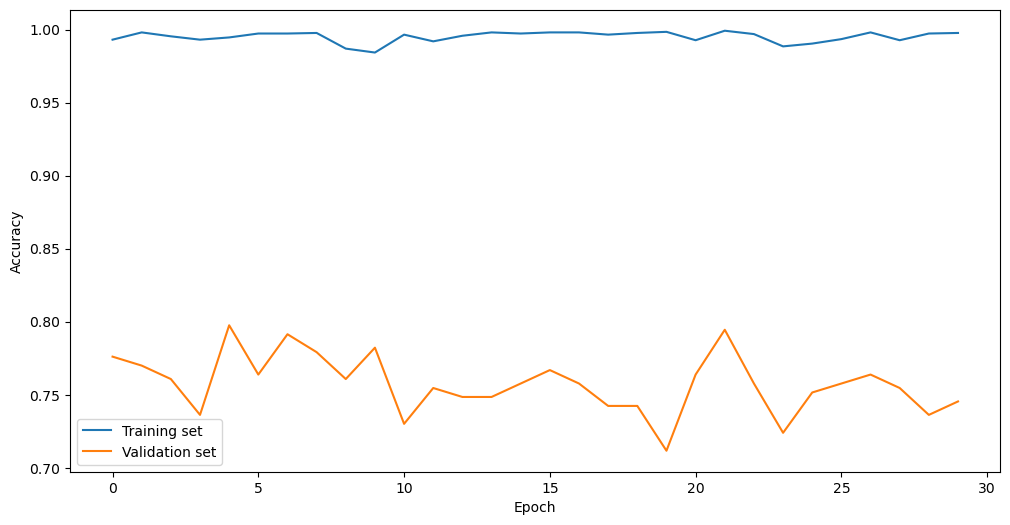

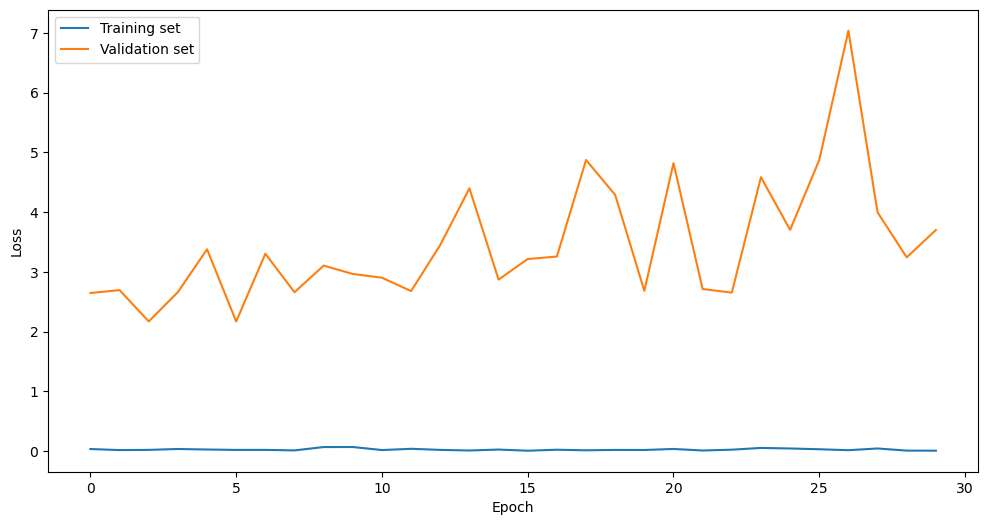

In [75]:
plot(Train_acc_list,Val_acc_list,"Accuracy")
plot(Train_loss_list,Val_loss_list,"Loss")

## Test Results ##

Test accuracy is 0.824031998598369
F score is 0.7663300602133015
Precision is 0.7681800491440081
Recall is 0.8202803978049217
Confusion matrix is below 
 AxesSubplot(0.125,0.11;0.62x0.77)


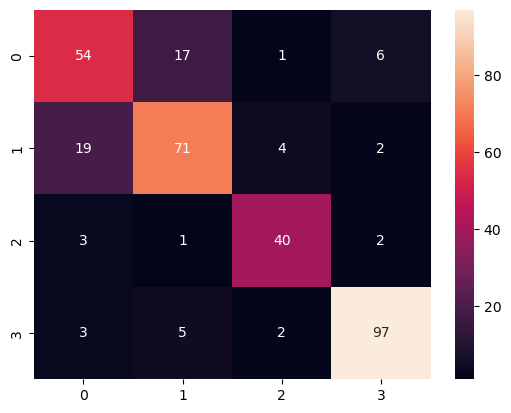

In [76]:
test_acc_list, f_score_list, p_score_list, r_score_list, cm_list = test(CNN_model,test_set)
report_test(test_acc_list, f_score_list, p_score_list, r_score_list, cm_list)

 # Training & Testing pre trained ResNet model

In [34]:
Train_loss_list1, Val_loss_list1, Val_acc_list1, Train_acc_list1 = train(model_resnet_pretrained,train_set,val_set,max_epoch,train_batch,val_batch,learning_rate)

Epoch 60: 100%|██████████████████████████████████████| 41/41 [00:18<00:00,  2.27it/s, train_acc=0.88, train_loss=0.573]


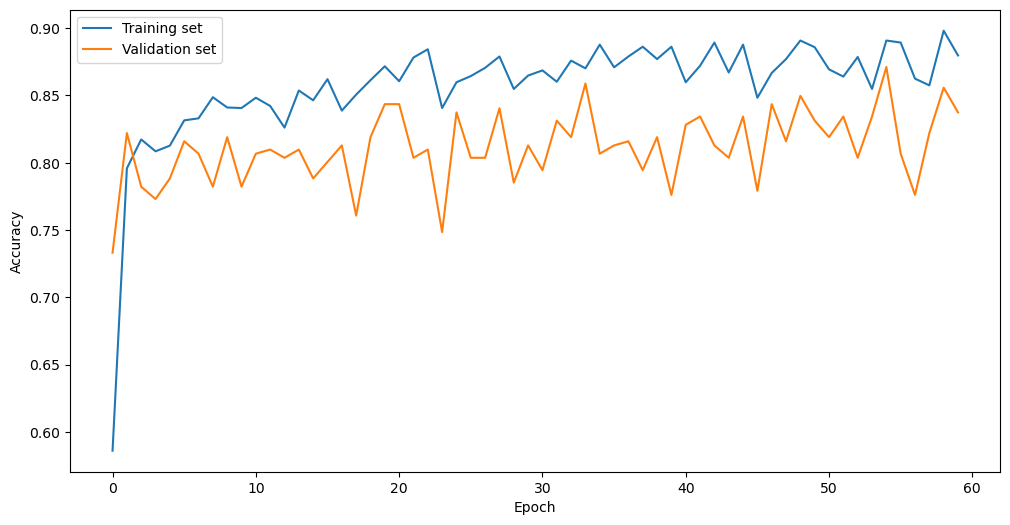

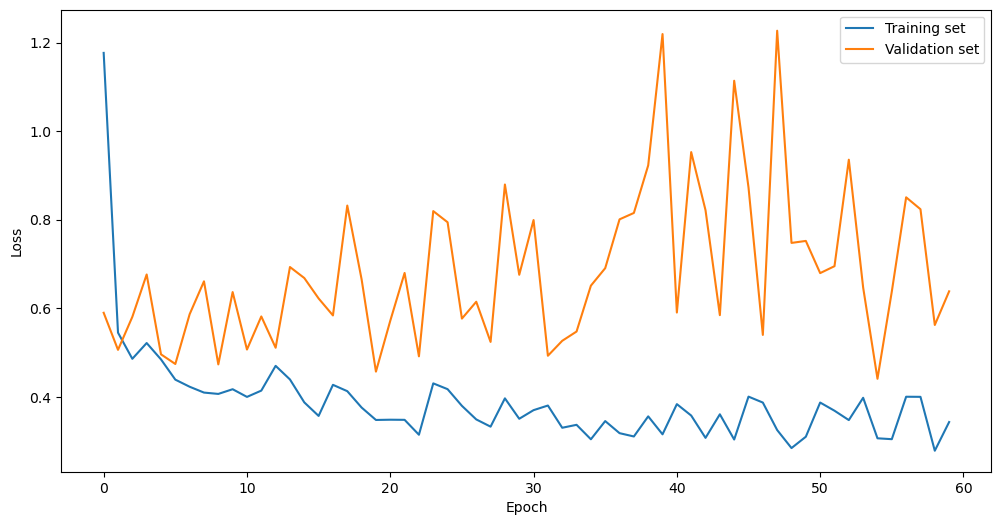

In [35]:
plot(Train_acc_list1,Val_acc_list1,"Accuracy")
plot(Train_loss_list1,Val_loss_list1,"Loss")

Test accuracy is 0.8469984390927626
F score is 0.8220797319829681
Precision is 0.8630974757812994
Recall is 0.8405231509546525
Confusion matrix is below 
 AxesSubplot(0.125,0.11;0.62x0.77)


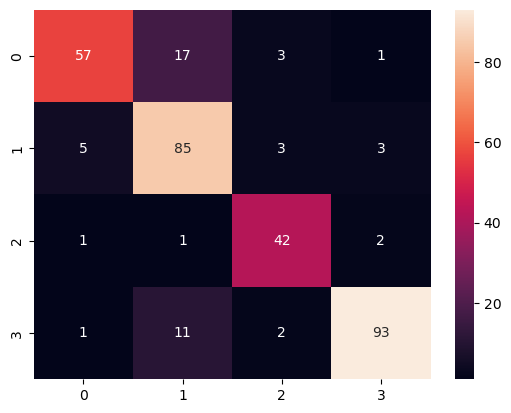

In [58]:
test_acc_list1, f_score_list1, p_score_list1, r_score_list1, cm_list1 = test(model_resnet_pretrained,test_set)
report_test(test_acc_list1, f_score_list1, p_score_list1, r_score_list1, cm_list1)

 # Training & Testing pre trained EffNet model

In [27]:
Train_loss_list2, Val_loss_list2, Val_acc_list2, Train_acc_list2 = train(model_efficientnet_b0_pretrained,train_set,val_set,max_epoch,train_batch,val_batch,learning_rate,momentum,weight_decay)

Epoch 60: 100%|█████████████████████████████████████| 41/41 [00:13<00:00,  3.06it/s, train_acc=0.903, train_loss=0.304]


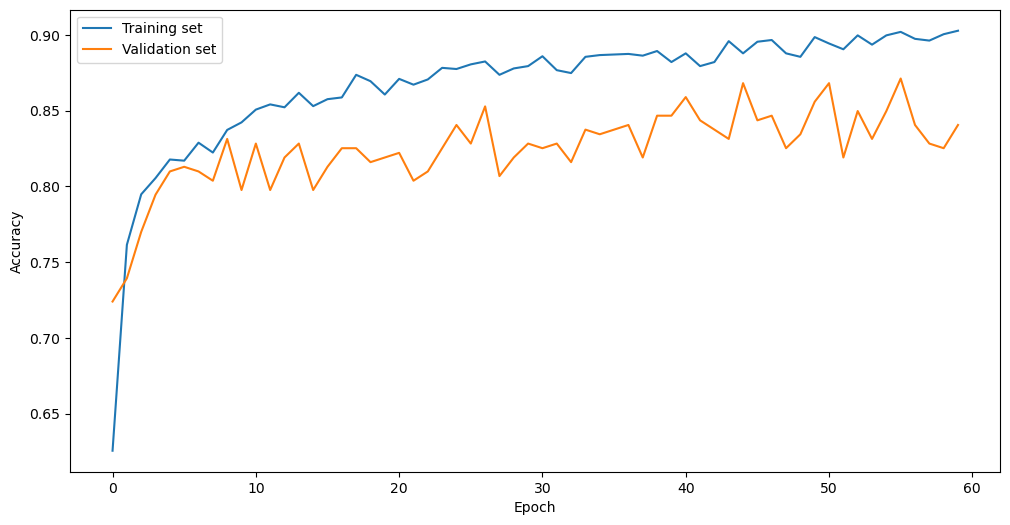

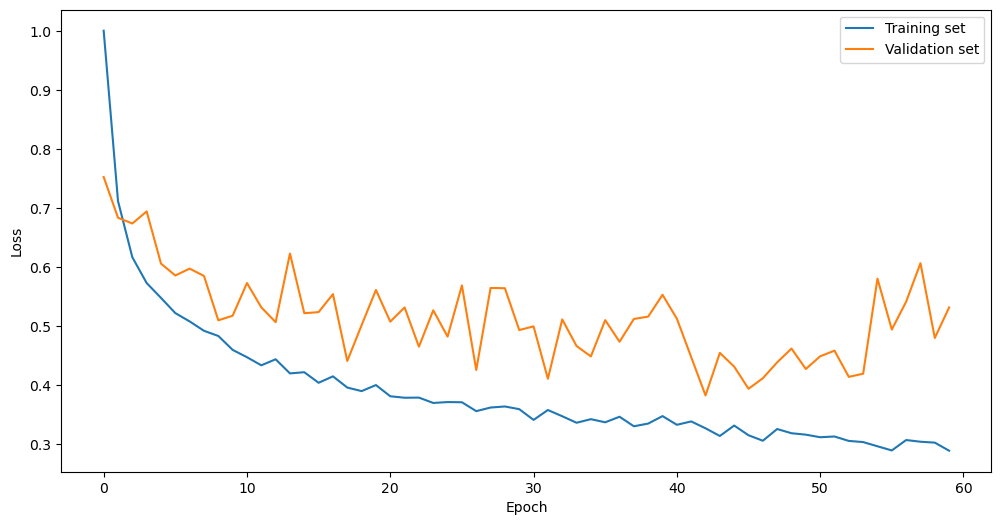

In [28]:
plot(Train_acc_list2,Val_acc_list2,"Accuracy")
plot(Train_loss_list2,Val_loss_list2,"Loss")

Test accuracy is 0.8576086264016309
F score is 0.8467898246188145
Precision is 0.8480800053990843
Recall is 0.858481506919007
Confusion matrix is below 
 AxesSubplot(0.125,0.11;0.62x0.77)


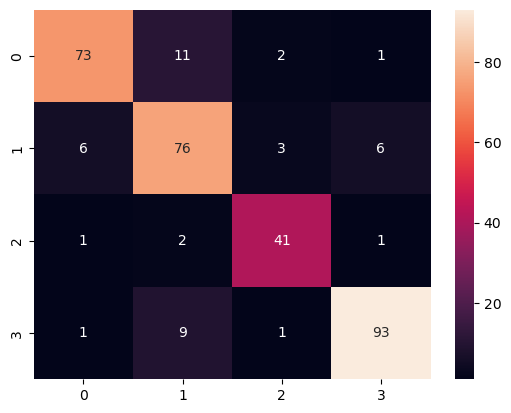

In [29]:
test_acc_list2, f_score_list2, p_score_list2, r_score_list2, cm_list2 = test(model_efficientnet_b0_pretrained,test_set)
report_test(test_acc_list2, f_score_list2, p_score_list2, r_score_list2, cm_list2)

 # Training & Testing not pre trained ResNet model

In [40]:
Train_loss_list3, Val_loss_list3, Val_acc_list3, Train_acc_list3 = train(model_resnet_not_pretrained,train_set,val_set,max_epoch,train_batch,val_batch,learning_rate)

Epoch 60: 100%|█████████████████████████████████████| 41/41 [00:18<00:00,  2.19it/s, train_acc=0.696, train_loss=0.763]


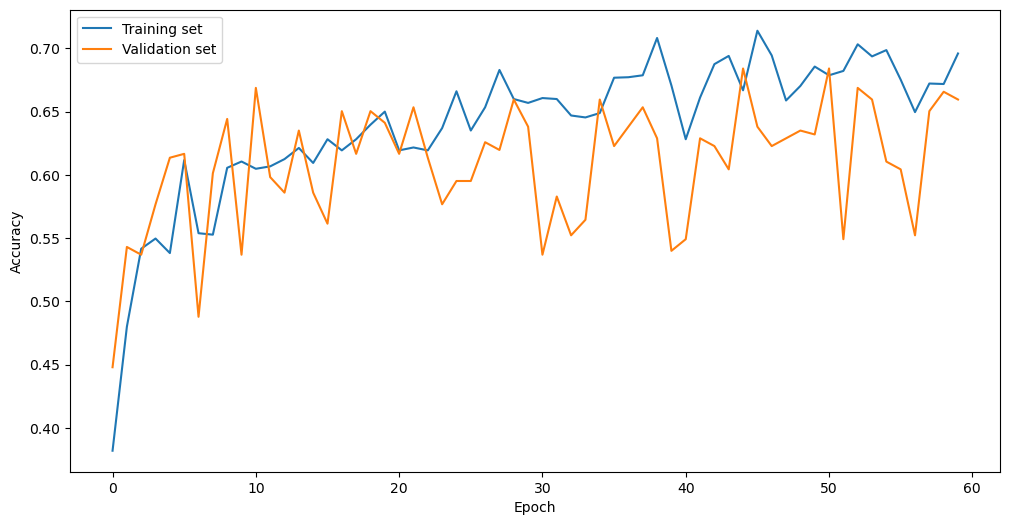

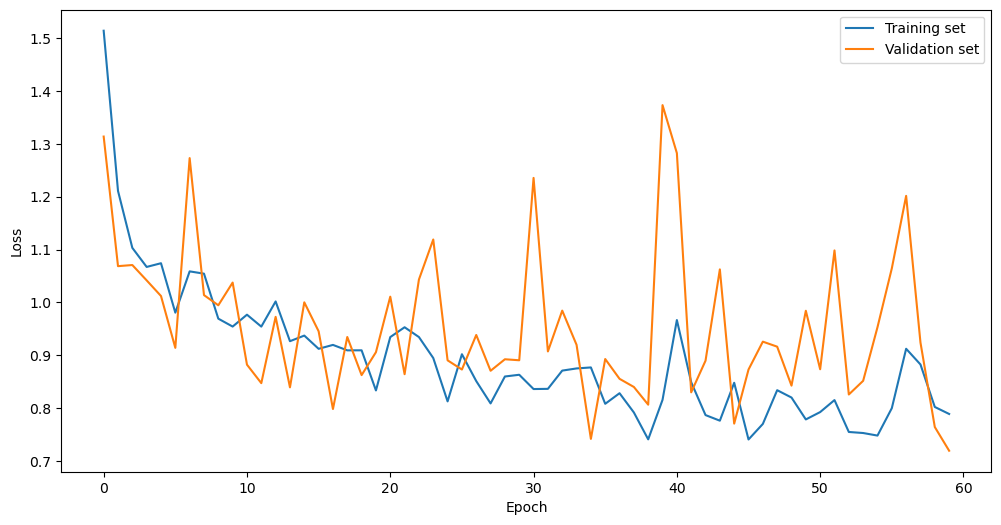

In [41]:
plot(Train_acc_list3,Val_acc_list3,"Accuracy")
plot(Train_loss_list3,Val_loss_list3,"Loss")

Test accuracy is 0.6344207919215087
F score is 0.5646264212053685
Precision is 0.6436996467796373
Recall is 0.5865889237458847
Confusion matrix is below 
 AxesSubplot(0.125,0.11;0.62x0.77)


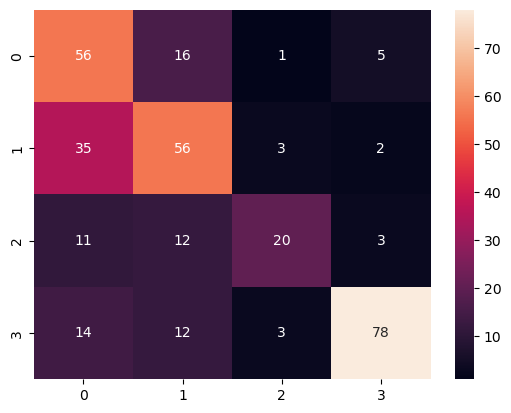

In [42]:
test_acc_list3, f_score_list3, p_score_list3, r_score_list3, cm_list3 = test(model_resnet_not_pretrained,test_set)
report_test(test_acc_list3, f_score_list3, p_score_list3, r_score_list3, cm_list3)

 # Training & Testing not pre trained EffNet model

In [43]:
Train_loss_list4, Val_loss_list4, Val_acc_list4, Train_acc_list4 = train(model_efficientnet_b0_not_pretrained,train_set,val_set,max_epoch,train_batch,val_batch,learning_rate)

Epoch 60: 100%|█████████████████████████████████████| 41/41 [00:17<00:00,  2.31it/s, train_acc=0.896, train_loss=0.492]


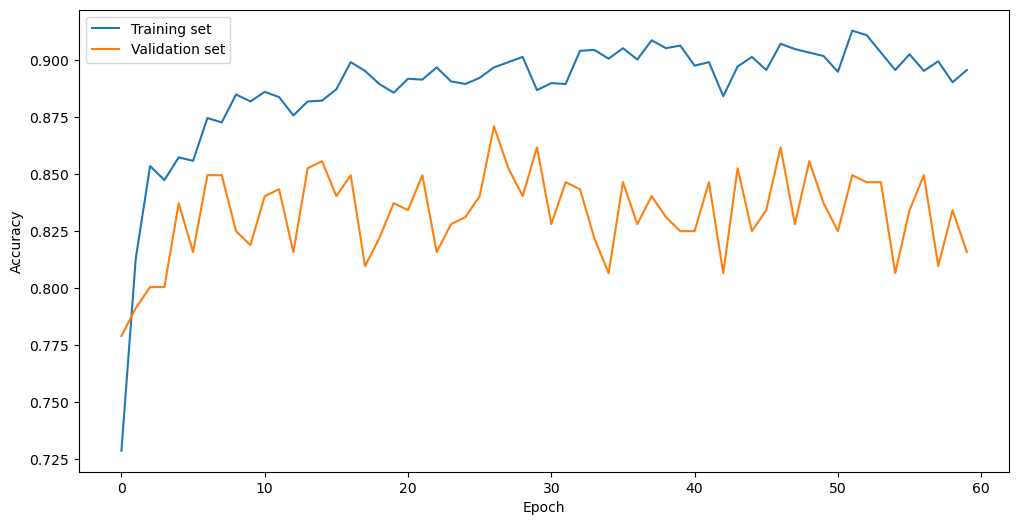

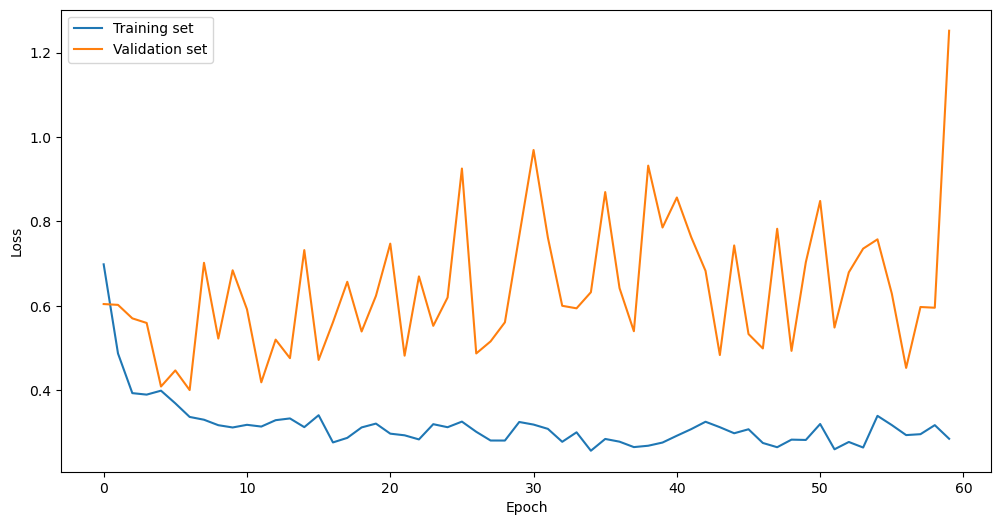

In [44]:
plot(Train_acc_list4,Val_acc_list4,"Accuracy")
plot(Train_loss_list4,Val_loss_list4,"Loss")

Test accuracy is 0.8351642138124363
F score is 0.7163208405357264
Precision is 0.7367492954886531
Recall is 0.8337575400462397
Confusion matrix is below 
 AxesSubplot(0.125,0.11;0.62x0.77)


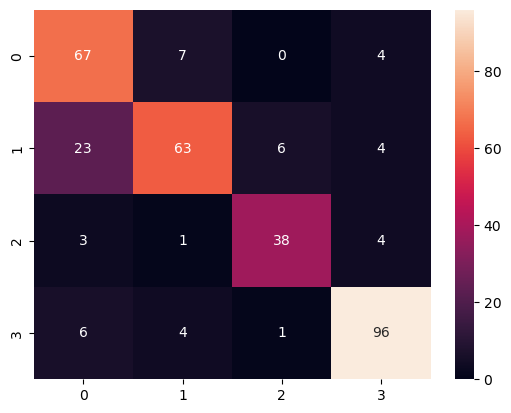

In [51]:
test_acc_list4, f_score_list4, p_score_list4, r_score_list4, cm_list4 = test(model_efficientnet_b0_not_pretrained,test_set)
report_test(test_acc_list4, f_score_list4, p_score_list4, r_score_list4, cm_list4)